# 学习目标
1.学习数据的可视化visualization
2.连续数据和分类数据
3.heatmap、pairplots、t-SNE为线性模型组织合适输入参数
from https://www.kaggle.com/dgawlik/house-prices-advanced-regression-techniques/house-prices-eda

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import sklearn.linear_model as linear_model
import seaborn as sns
#import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%matplotlib inline

pd.options.display.max_rows=1000
pd.options.display.max_columns=20

train=pd.read_csv(r"train.csv")
test=pd.read_csv(r"test.csv")

quantitative=[f for f in train.columns if train.dtypes[f]!="object"]
qualitative=[f for f in train.columns if train.dtypes[f]=="object"]
quantitative.remove("SalePrice")
quantitative.remove("Id")


#### 36个定量变量quantitative 43个定性变量(分类变量)qualitative

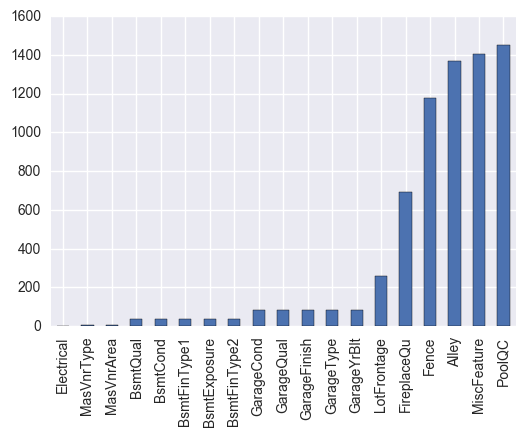

In [2]:
missing=train.isnull().sum()
missing=missing[missing>0]
missing.sort_values(inplace=True)
missing.plot.bar()

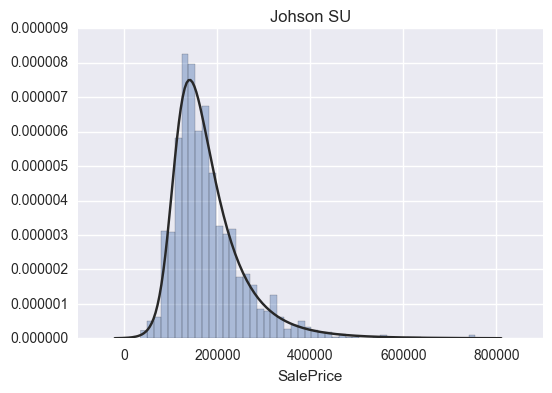

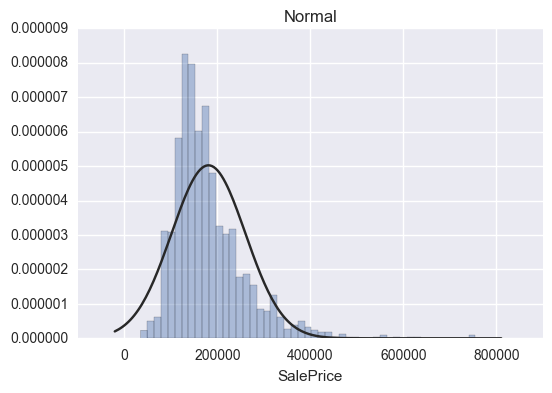

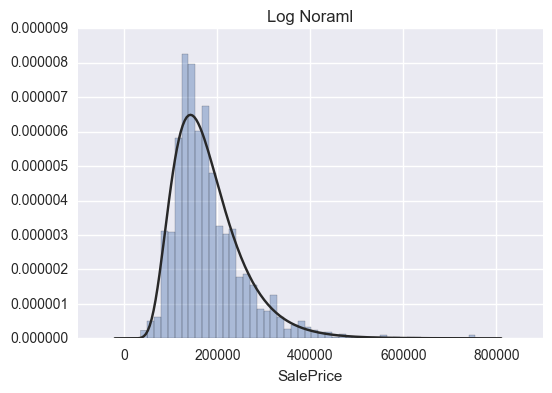

In [3]:
#saleprice doesn't follow normal distribution 符合Johnson分布
y=train["SalePrice"]
plt.figure(1);plt.title("Johson SU")
sns.distplot(y,kde=False,fit=st.johnsonsu)
plt.figure(2);plt.title("Normal")
sns.distplot(y,kde=False,fit=st.norm)
plt.figure(3);plt.title("Log Noraml")
sns.distplot(y,kde=False,fit=st.lognorm)

D:\Anaconda\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


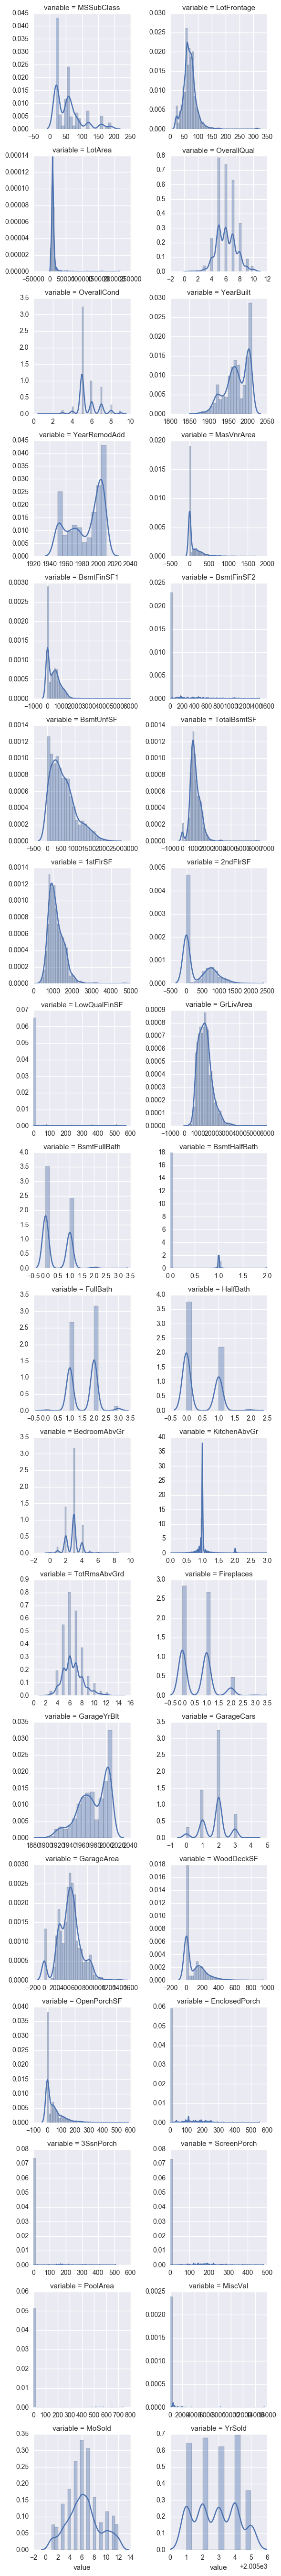

In [4]:
f=pd.melt(train,value_vars=quantitative)
g=sns.FacetGrid(f,col="variable",col_wrap=2,sharex=False,sharey=False)
g=g.map(sns.distplot,"value")

## 分类变量categorical data 
1.枚举变量关于Saleprice的分布
2.创建虚拟变量-哑指标

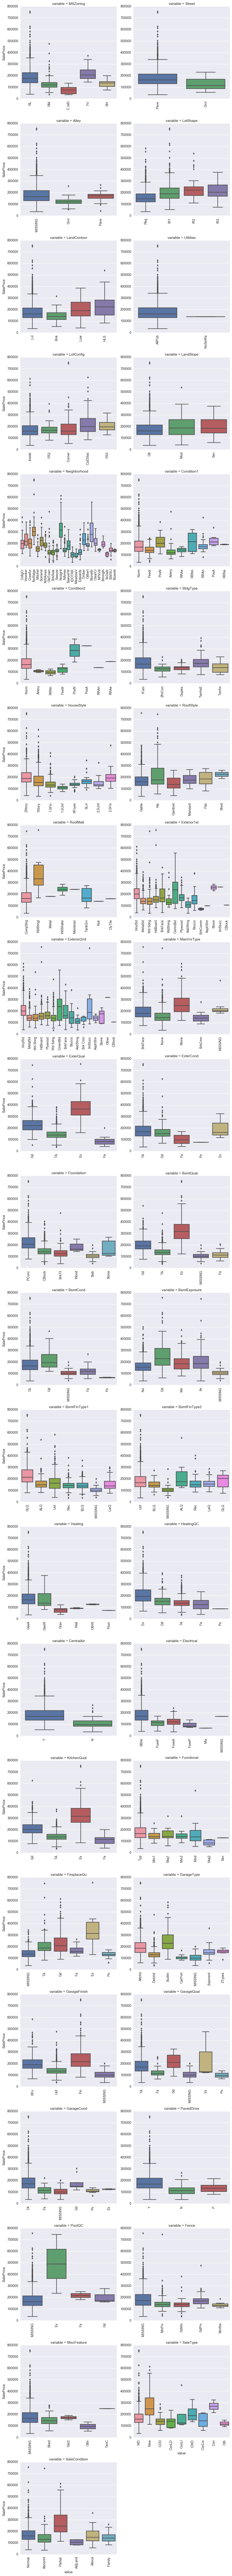

In [5]:
for c in qualitative:
    train[c]=train[c].astype("category")
    if train[c].isnull().any():#检查是否存在缺失值
        train[c]=train[c].cat.add_categories(["MISSING"])#添加缺失值分类变量
        train[c]=train[c].fillna("MISSING")#补充缺失值
        
def boxplot(x,y,**kwargs):
    sns.boxplot(x=x,y=y)
    x=plt.xticks(rotation=90)
    
f=pd.melt(train,id_vars=["SalePrice"],value_vars=qualitative)
g=sns.FacetGrid(f,col="variable",col_wrap=2,sharex=False,sharey=False,size=5)
g=g.map(boxplot,"value","SalePrice")


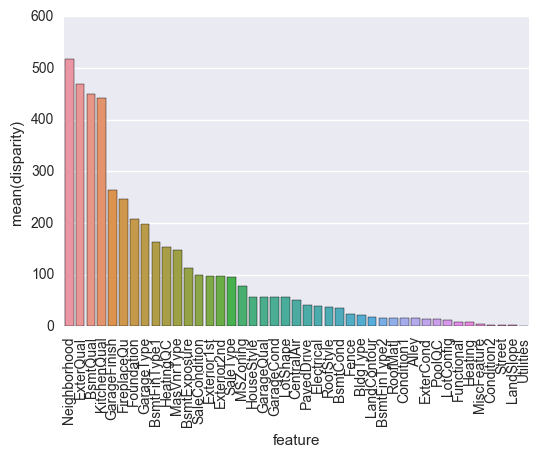

In [6]:
def anova(frame):
    anv=pd.DataFrame()
    anv["feature"]=qualitative
    pvals=[]
    for c in qualitative:
        samples=[]
        for cls in frame[c].unique():
            s=frame[frame[c]==cls]["SalePrice"].values
            samples.append(s)
        pval=st.f_oneway(*samples)[1]#单因素方差分析，返回检验P值
        pvals.append(pval)
    anv["pval"]=pvals
    return anv.sort_values("pval")

a=anova(train)
a["disparity"]=np.log(1/a["pval"].values)
sns.barplot(data=a,x="feature",y="disparity")
x=plt.xticks(rotation=90)

In [7]:
def encode(frame,feature):
    ordering=pd.DataFrame()
    ordering["val"]=frame[feature].unique()
    ordering.index=ordering.val
    ordering["spmean"]=frame[[feature,"SalePrice"]].groupby(feature).mean()["SalePrice"]
    ordering=ordering.sort_values("spmean")
    ordering["ordering"]=range(1,ordering.shape[0]+1)
    ordering=ordering["ordering"].to_dict()
    
    for cat,o in ordering.items():
        frame.loc[frame[feature]==cat,feature+"_E"]=o
        
qual_encoded=[]
for q in qualitative:
    encode(train,q)
    qual_encoded.append(q+"_E")
    
print(qual_encoded)

['MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'SaleType_E', 'SaleCondition_E']


In [8]:
train["MSZoning"].unique()

[RL, RM, C (all), FV, RH]
Categories (5, object): [RL, RM, C (all), FV, RH]

### 变量相关性correlations

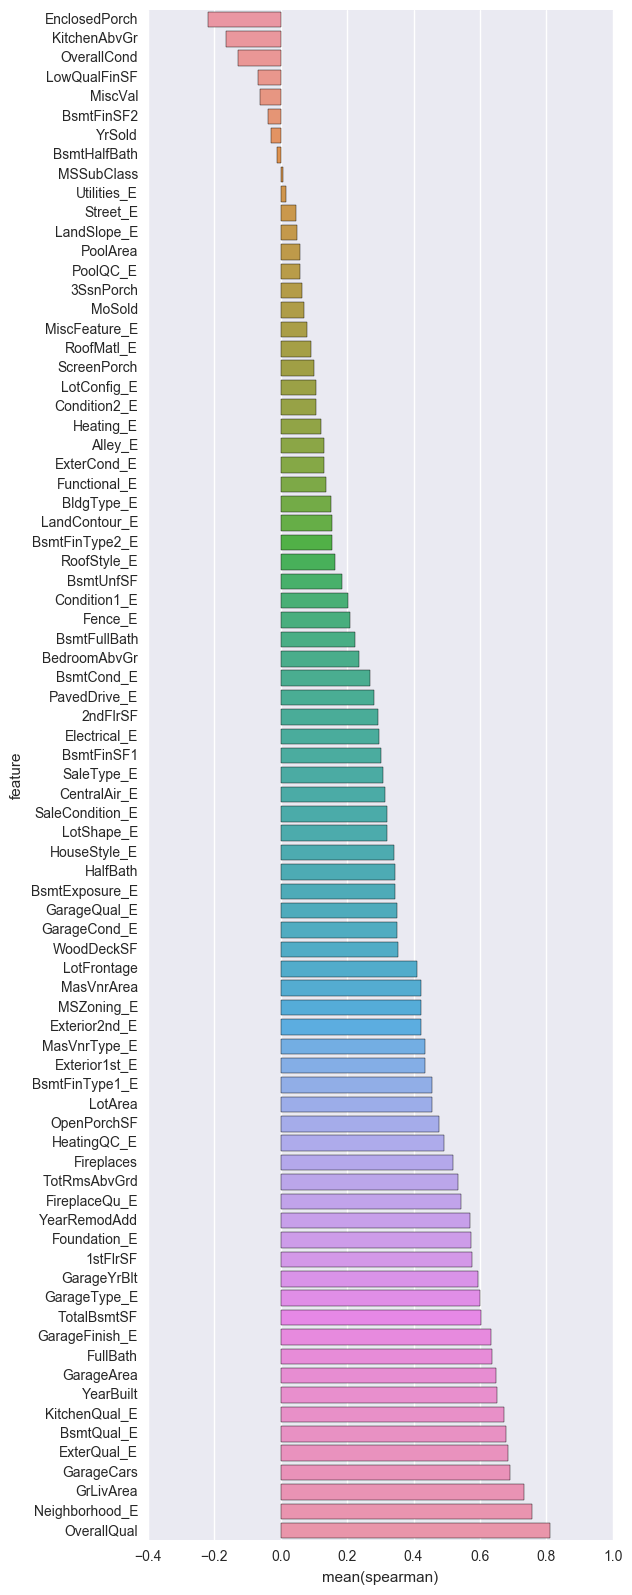

In [9]:
def spearman(frame,features):
    spr=pd.DataFrame()
    spr["feature"]=features
    spr["spearman"]=[frame[f].corr(frame["SalePrice"],"spearman") 
                     for f in features]
    spr=spr.sort_values("spearman")
    plt.figure(figsize=(6,0.25*len(features)))
    sns.barplot(data=spr,y="feature",x="spearman",orient="h")
    
fratures=quantitative+qual_encoded
spearman(train,fratures)

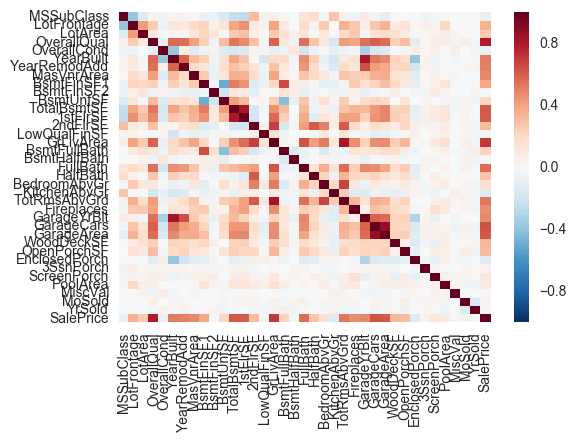

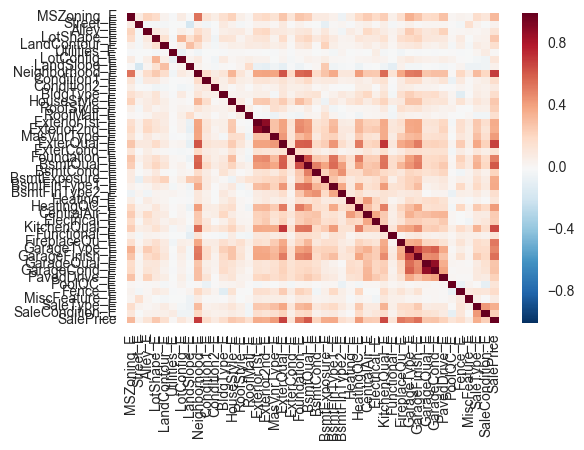

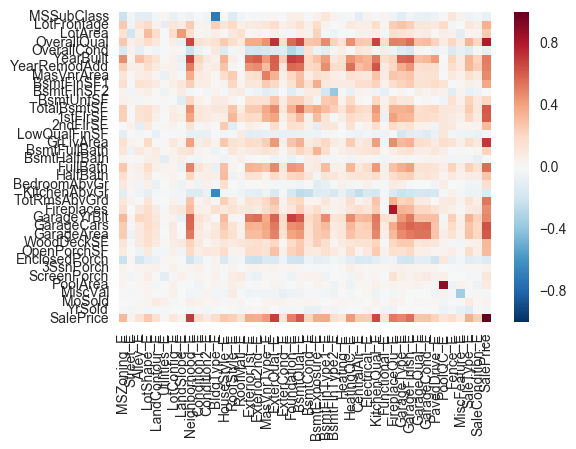

In [10]:
plt.figure(1)
corr=train[quantitative+["SalePrice"]].corr()
sns.heatmap(corr)
plt.figure(2)
corr=train[qual_encoded+["SalePrice"]].corr()
sns.heatmap(corr)
plt.figure(3)
corr=pd.DataFrame(np.zeros([len(quantitative)+1,len(qual_encoded)+1]),
                  index=quantitative+["SalePrice"],columns=qual_encoded+["SalePrice"])
for q1 in quantitative+["SalePrice"]:
    for q2 in qual_encoded+["SalePrice"]:
        corr.loc[q1,q2]=train[q1].corr(train[q2])
sns.heatmap(corr)

### pairplot

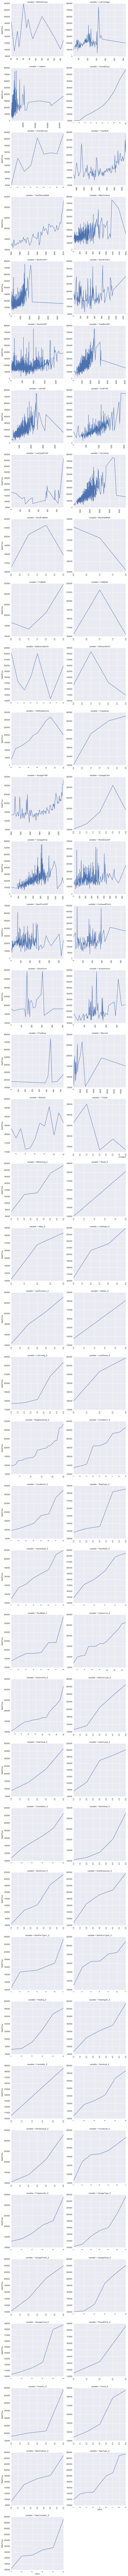

In [11]:
def pairplot(x,y,**kwargs):
    ax=plt.gca()
    ts=pd.DataFrame({"time":x,"val":y})
    ts=ts.groupby("time").mean()
    ts.plot(ax=ax)
    plt.xticks(rotation=90)
    
f=pd.melt(train,id_vars=["SalePrice"],value_vars=quantitative+qual_encoded)
g=sns.FacetGrid(f,col="variable",col_wrap=2,sharex=False,sharey=False,size=5)
g=g.map(pairplot,"value","SalePrice")

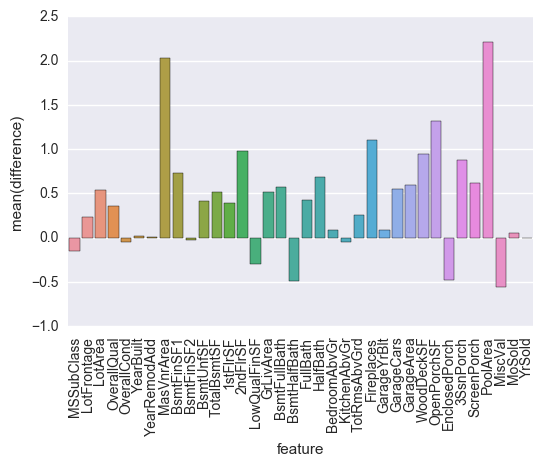

In [12]:
features=quantitative

standard=train[train["SalePrice"]<200000]
pricey=train[train["SalePrice"]>=200000]

diff=pd.DataFrame()
diff["feature"]=features
diff["difference"]=[(pricey[f].fillna(0.).mean()-
                     standard[f].fillna(0.).mean())/(standard[f].fillna(0.).mean())
                   for f in features]

sns.barplot(data=diff,x="feature",y="difference")
x=plt.xticks(rotation=90)

### Clustering

0.749833261689


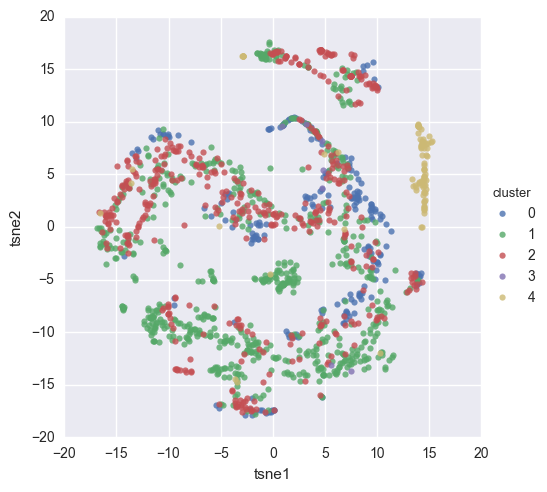

In [23]:
features=quantitative+qual_encoded
model=TSNE(n_components=2,random_state=0,perplexity=50)
X=train[features].fillna(0.).values
tsne=model.fit_transform(X)

std=StandardScaler()
s=std.fit_transform(X)
pca=PCA(n_components=30)
pca.fit(s)
pc=pca.transform(s)
kmeans=KMeans(n_clusters=5)
kmeans.fit(pc)

fr=pd.DataFrame({"tsne1":tsne[:,0],"tsne2":tsne[:,1],"cluster":kmeans.labels_})
sns.lmplot(data=fr,x="tsne1",y="tsne2",hue="cluster",fit_reg=False)
print(np.sum(pca.explained_variance_ratio_))

D:\Anaconda\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


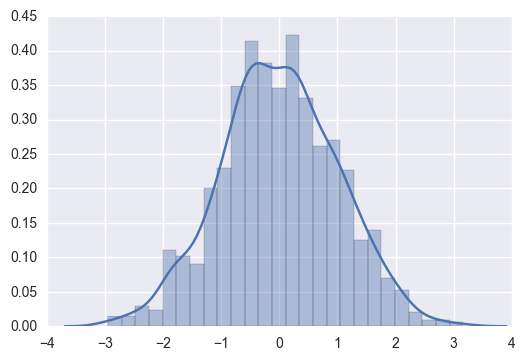

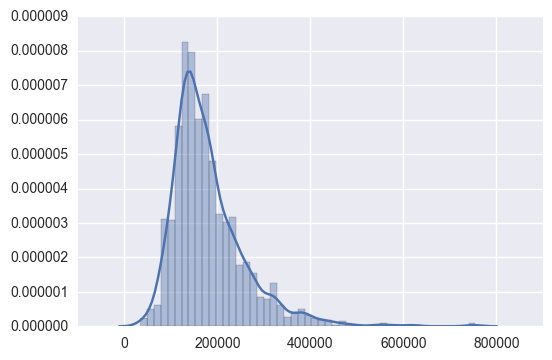

In [26]:
y=train["SalePrice"].values
def johnson(y):
    gamma,eta,epsilon,lbda=st.johnsonsu.fit(y)
    yt=gamma+eta*np.arcsinh((y-epsilon)/lbda)
    return yt,gamma,eta,epsilon,lbda

def johnson_inverse(y,gamma,eta,epsilon,lbda):
    return lbda*np.sinh((y-gamma)/eta)+epsilon

yt,g,et,ep,l=johnson(y)
yt2=johnson_inverse(yt,g,et,ep,l)
plt.figure(1)
sns.distplot(yt)
plt.figure(2)
sns.distplot(yt2)


### Regression

In [31]:
def error(actual,predicted):
    actual=np.log(actual)
    prdicted=np.log(predicted)
    return np.sqrt(np.sum(np.square(actual-predicted))/len(actual))

def log_transform(feature):
    train[feature]=np.log1p(train[feature].values)
    
def quadratic(feature):
    train[feature+"2"]=train[feature]**2

In [32]:
log_transform('GrLivArea')
log_transform('1stFlrSF')
log_transform('2ndFlrSF')
log_transform('TotalBsmtSF')
log_transform('LotArea')
log_transform('LotFrontage')
log_transform('KitchenAbvGr')
log_transform('GarageArea')

quadratic('OverallQual')
quadratic('YearBuilt')
quadratic('YearRemodAdd')
quadratic('TotalBsmtSF')
quadratic('2ndFlrSF')
quadratic('Neighborhood_E')
quadratic('RoofMatl_E')
quadratic('GrLivArea')

In [36]:
qdr = ['OverallQual2', 'YearBuilt2', 'YearRemodAdd2', 'TotalBsmtSF2',
        '2ndFlrSF2', 'Neighborhood_E2', 'RoofMatl_E2', 'GrLivArea2']

train['HasBasement'] = train['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
train['HasGarage'] = train['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
train['Has2ndFloor'] = train['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
train['HasMasVnr'] = train['MasVnrArea'].apply(lambda x: 1 if x > 0 else 0)
train['HasWoodDeck'] = train['WoodDeckSF'].apply(lambda x: 1 if x > 0 else 0)
train['HasPorch'] = train['OpenPorchSF'].apply(lambda x: 1 if x > 0 else 0)
train['HasPool'] = train['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
train['IsNew'] = train['YearBuilt'].apply(lambda x: 1 if x > 2000 else 0)

boolean = ['HasBasement', 'HasGarage', 'Has2ndFloor', 'HasMasVnr', 'HasWoodDeck',
            'HasPorch', 'HasPool', 'IsNew']



In [37]:
features = quantitative + qual_encoded + boolean + qdr
lasso = linear_model.LassoLarsCV(max_iter=10000)
X = train[features].fillna(0.).values
Y = train['SalePrice'].values
lasso.fit(X, np.log(Y))

Ypred = np.exp(lasso.predict(X))
error(Y, Ypred)

D:\Anaconda\lib\site-packages\sklearn\linear_model\least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 104 iterations, alpha=2.473e-03, previous alpha=3.161e-06, with an active set of 89 regressors.
  ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\linear_model\least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 99 iterations, alpha=7.284e-04, previous alpha=1.624e-05, with an active set of 78 regressors.
  ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\linear_model\least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 99 iterations, alpha=3.151e-04, previous alpha=1.429e-06, with an active set of 88 regressors.
  ConvergenceWarning)


193631.40421132039

In [38]:
import patsy

Y, X = patsy.dmatrices(
    "SalePrice ~ \
        GarageCars + \
        np.log1p(BsmtFinSF1) + \
        ScreenPorch + \
        Condition1_E + \
        Condition2_E + \
        WoodDeckSF + \
        np.log1p(LotArea) + \
        Foundation_E + \
        MSZoning_E + \
        MasVnrType_E + \
        HouseStyle_E + \
        Fireplaces + \
        CentralAir_E + \
        BsmtFullBath + \
        EnclosedPorch + \
        PavedDrive_E + \
        ExterQual_E + \
        bs(OverallCond, df=7, degree=1) + \
        bs(MSSubClass, df=7, degree=1) + \
        bs(LotArea, df=2, degree=1) + \
        bs(FullBath, df=3, degree=1) + \
        bs(HalfBath, df=2, degree=1) + \
        bs(BsmtFullBath, df=3, degree=1) + \
        bs(TotRmsAbvGrd, df=2, degree=1) + \
        bs(LandSlope_E, df=2, degree=1) + \
        bs(LotConfig_E, df=2, degree=1) + \
        bs(SaleCondition_E, df=3, degree=1) + \
        OverallQual + np.square(OverallQual) + \
        GrLivArea + np.square(GrLivArea) + \
        Q('1stFlrSF') + np.square(Q('1stFlrSF')) + \
        Q('2ndFlrSF') + np.square(Q('2ndFlrSF')) +  \
        TotalBsmtSF + np.square(TotalBsmtSF) +  \
        KitchenAbvGr + np.square(KitchenAbvGr) +  \
        YearBuilt + np.square(YearBuilt) + \
        Neighborhood_E + np.square(Neighborhood_E) + \
        Neighborhood_E:OverallQual + \
        MSSubClass:BldgType_E + \
        ExterQual_E:OverallQual + \
        PoolArea:PoolQC_E + \
        Fireplaces:FireplaceQu_E + \
        OverallQual:KitchenQual_E + \
        GarageQual_E:GarageCond + \
        GarageArea:GarageCars + \
        Q('1stFlrSF'):TotalBsmtSF + \
        TotRmsAbvGrd:GrLivArea",
    train.to_dict('list'))

ridge = linear_model.RidgeCV(cv=10)
ridge.fit(X, np.log(Y))
Ypred = np.exp(ridge.predict(X))
print(error(Y,Ypred))

193930.47882651203
